In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

In [2]:
class action_space(object):
    def __init__(self, env):
        self.env = env
        self.high = np.array([ 1,  1,  1,  1,  1])
        self.low = -np.array([ 1,  1,  1,  1,  1])
        self.shape = env.observation_space.shape
    
    def sample(self):
    
        return self.env.observation_space.sample()
        
        
class adversial_env(object):
    def __init__(self):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.ratio = 0.7
        self.threshold = np.array([ 0.14244403,  0.07706523,  0.00016789,  0.00789366,  0.02395424])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])+0.2*np.abs(st[1])-0.08#
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        ac = self.agent.act(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
            
        
        final_r = self.reward(self.obsr)
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[0:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('cumulative reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[0:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('number of time steps',fontsize=fon_size)
        plt.show()

# define an observer (new agent)

In [3]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 15000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 55
        
args = par()
env = adversial_env()
agn = agent(env, args)
#agn.load_model('agent_model/adversarial_agent2_distr')

[2018-03-09 19:41:02,629] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [4]:
agn.learn()

-66.7758301304 [-66.775830130447346] [1000]
Episode 0	Last reward: -65.84032715041106	Average reward -65.78
('lagrange multiplier:', 0.3948367989834848, 'grad_norm:', 0.0447429257491688)
fval before -1.1627254714596802e-14
a/e/r 0.007447226637131457 0.007896735979669776 0.9430765643304291
fval after -0.007447226637143084
Episode 1	Last reward: -67.46247183809099	Average reward -65.42
('lagrange multiplier:', 0.24174362380016098, 'grad_norm:', 0.04041465505968838)
fval before 1.9306778398231473e-16
a/e/r 0.004597748231196259 0.004834872476003331 0.9509554293346973
fval after -0.004597748231196065
Episode 2	Last reward: -61.90977957733921	Average reward -64.91
('lagrange multiplier:', 0.26170742887669435, 'grad_norm:', 0.05146724482997622)
fval before -1.0430545316353346e-16
a/e/r 0.005435278279161589 0.005234148577533685 1.0384264410244686
fval after -0.005435278279161693
Episode 3	Last reward: -66.39681079441641	Average reward -65.33
('lagrange multiplier:', 0.3830977971097054, 'grad_n

KeyboardInterrupt: 

In [ ]:
env.result_plot()

# Agent evaluation

In [ ]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

In [ ]:
env.result_plot()

# Save model

In [ ]:
agn.save_model('agent_model/adversarial_agent2_distr')

# adversarial evaluation

In [5]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

In [6]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 15000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 55
        
args = par()
env = adversial_env()
agn = agent(env, args)
agn.load_model('agent_model/adversarial_agent2_distr')

[2018-03-09 19:45:11,483] Making new env: RoboschoolInvertedPendulum-v1


In [7]:
env = adversial_env()
action = []
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        action.append(np.clip(a,-1,1))
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-03-09 19:45:12,028] Making new env: RoboschoolInvertedPendulum-v1


-5.10594686693 [-5.1059468669275505] [279]


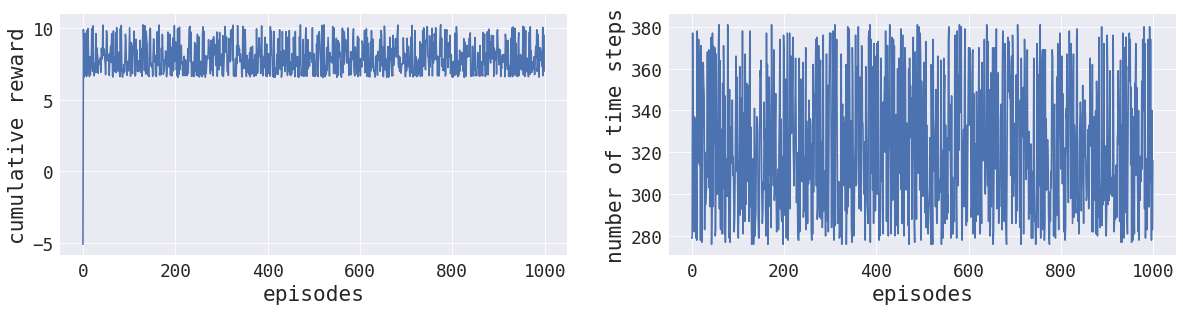

In [8]:
env.result_plot()

In [9]:
np.array(action)

array([[ 0.94962   ,  1.        , -0.70452132,  1.        ,  1.        ],
       [ 0.21332354,  1.        , -1.        ,  1.        ,  1.        ],
       [ 0.14726498,  1.        , -1.        ,  1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        , -0.14163598,  1.        ,  1.        ],
       [ 1.        ,  1.        , -0.14164189,  1.        ,  1.        ],
       [ 1.        ,  1.        , -0.14164663,  1.        ,  1.        ]])

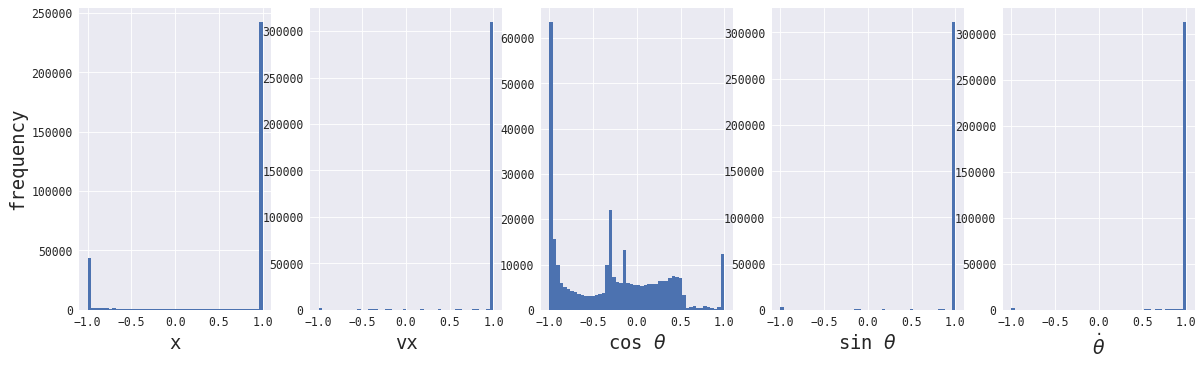

In [13]:
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,0], bins = bin_num)
plt.xlabel('x', fontsize=fon_size)
plt.ylabel('frequency', fontsize=fon_size)

plt.subplot(1,5,2)
plt.hist(sensor_array[:,1], bins = bin_num)
plt.xlabel('vx', fontsize=fon_size)

plt.subplot(1,5,3)
plt.hist(sensor_array[:,2], bins = bin_num)
plt.xlabel(r'cos $\theta$', fontsize=fon_size)

plt.subplot(1,5,4)
plt.hist(sensor_array[:,3], bins = bin_num)
plt.xlabel(r'sin $\theta$', fontsize=fon_size)

plt.subplot(1,5,5)
plt.hist(sensor_array[:,4], bins = bin_num)
plt.xlabel(r'$\dot \theta$', fontsize=fon_size)

plt.show()